In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from func import (compute_pi_nsw, 
                  compute_pi_unif,
                  synthesize_rel_mat, 
                  exam_func,
                  evaluate_pi)

In [2]:
n_query = 200
n_doc = 100
default_lam = 0.9
default_noise = 0.05
flip_ratio = 0.3
random_state = 1234
n_seeds = 10

k_list = [1, 3, 5, 10, 15, 20]
n_doc_list = [50, 60, 70, 80, 90]

query_doc_ratio = 2

In [3]:
result = []

for seed in range(n_seeds):

    rel_mat_true, rel_mat_obs = synthesize_rel_mat(
                        n_query=n_query,
                        n_doc=n_doc,
                        lam=default_lam,
                        noise=default_noise,
                        flip_ratio=flip_ratio,
                        random_state=random_state + seed,
                    )
    
    for n_doc_ in tqdm(n_doc_list):

        if query_doc_ratio is not None:
            n_query_ = n_doc_ * query_doc_ratio
        else:
            n_query_ = n_query

        rel_mat = rel_mat_true[:n_query_, :n_doc_]

        for k in k_list:

            v = exam_func(n_doc_, k, "inv")

            # uniform
            pi_unif = compute_pi_unif(rel_mat=rel_mat, v=v)
            user_util_unif, item_utils_unif, max_envies_unif, _ = evaluate_pi(
                pi=pi_unif,
                rel_mat=rel_mat,
                v=v,
            )
        
            pi, cons1_duals, cons2_duals = compute_pi_nsw(rel_mat=rel_mat, v=v)

            user_util, item_utils, max_envies, _ = evaluate_pi(
                            pi=pi,
                            rel_mat=rel_mat,
                            v=v,
                        )
            
            mean_max_envy = max_envies.mean()
            pct_item_util_better_off = 100 * ((item_utils / item_utils_unif) > 1.10).mean()
            pct_item_util_worse_off = 100 * ((item_utils / item_utils_unif) < 0.90).mean()
            

            result.append({
                'seed': seed,
                'n_doc': n_doc_,
                'k': k,
                'mean_max_envies': mean_max_envy,
                'better_off': pct_item_util_better_off,
                'worse_off': pct_item_util_worse_off,
                'max_dual_1': cons1_duals.max(),
                'max_dual_2': cons2_duals.max()
            })

result_df = pd.DataFrame(result)

100%|██████████| 5/5 [02:20<00:00, 28.02s/it]


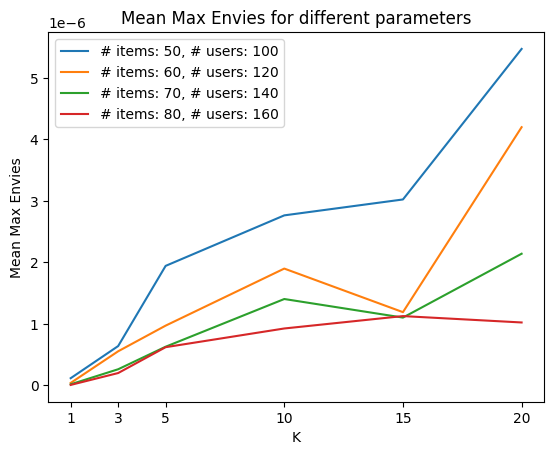

In [13]:
import matplotlib.pyplot as plt

n_doc_list = [50, 60, 70, 80]

for n_doc in n_doc_list:
    dft = result_df[result_df.n_doc == n_doc]
    dft = dft.groupby(['k'], as_index=False).mean()
    plt.plot(dft['k'], dft['mean_max_envies'], label=f"# items: {n_doc}, # users: {n_doc*query_doc_ratio}")

plt.title("Mean Max Envies for different parameters")
plt.ylabel("Mean Max Envies")
plt.xlabel("K")
plt.xticks(k_list, k_list)
plt.legend()


([<matplotlib.axis.XTick at 0x280c99e80>,
 [Text(1, 0, '1'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

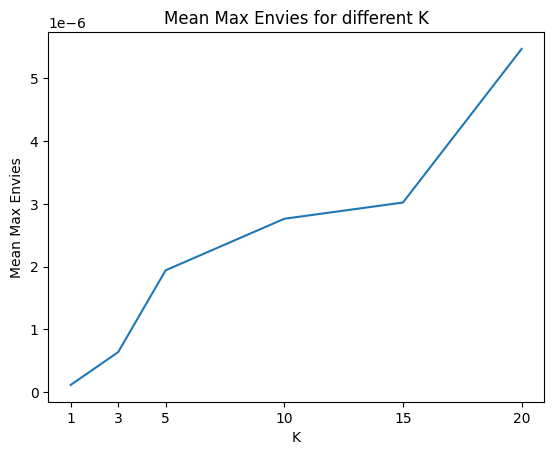

In [12]:
import matplotlib.pyplot as plt

n_doc_list = [50]

for n_doc in n_doc_list:
    dft = result_df[result_df.n_doc == n_doc]
    dft = dft.groupby(['k'], as_index=False).mean()
    plt.plot(dft['k'], dft['mean_max_envies'], label=f"# items: {n_doc}")

plt.title("Mean Max Envies for different K")
plt.ylabel("Mean Max Envies")
plt.xlabel("K")
plt.xticks(k_list, k_list)

In [6]:
dft = result_df[result_df.n_doc == n_doc]
dft.groupby

<bound method DataFrame.groupby of      seed  n_doc   k  mean_max_envies  better_off  worse_off    max_dual_1  \
6       0     60   1     5.269225e-08  100.000000        0.0  9.275054e-17   
7       0     60   3     3.242062e-07  100.000000        0.0  1.810506e-17   
8       0     60   5     1.349087e-06  100.000000        0.0  3.579396e-18   
9       0     60  10     2.259605e-06  100.000000        0.0  2.630599e-18   
10      0     60  15     1.558013e-06  100.000000        0.0  2.210304e-18   
11      0     60  20     3.838954e-06  100.000000        0.0  4.414536e-03   
36      1     60   1     5.914343e-11  100.000000        0.0  9.766592e-17   
37      1     60   3     9.042847e-07  100.000000        0.0  0.000000e+00   
38      1     60   5     2.457795e-07  100.000000        0.0  3.566121e-18   
39      1     60  10     1.015997e-06  100.000000        0.0  2.624503e-18   
40      1     60  15     8.342502e-07  100.000000        0.0  2.206968e-18   
41      1     60  20     5.48

In [7]:
result_df

,seed,n_doc,k,mean_max_envies,better_off,worse_off,max_dual_1,max_dual_2
0,0,50,1,7.384254e-09,30.0,0.0,1.015119e-16,0.610306
1,0,50,3,9.154645e-07,30.0,0.0,4.989374e-18,0.332894
2,0,50,5,1.914039e-06,30.0,0.0,3.826553e-18,0.267294
3,0,50,10,3.230891e-06,30.0,0.0,2.808833e-18,0.208368
4,0,50,15,4.050694e-06,30.0,0.0,8.637977e-04,0.183899
...,...,...,...,...,...,...,...,...
295,9,90,3,1.898661e-07,100.0,0.0,0.000000e+00,0.413450
296,9,90,5,1.190665e-06,100.0,0.0,0.000000e+00,0.331975
297,9,90,10,1.578993e-06,100.0,0.0,2.357137e-18,0.258802
298,9,90,15,1.776712e-06,100.0,0.0,1.998675e-18,0.228446


In [8]:


def get_n_twins(rel_mat_true, e=0.1):
    n_doc = rel_mat_true.shape[1]
    res = np.ones((n_doc, n_doc)) * np.inf
    for i in range(n_doc):
        for j in range(n_doc):
            if i != j:
                res[i,j] = np.max(np.abs(rel_mat_true[:, i] - rel_mat_true[:, j]))

    return (res < e).sum()